# 1. Data Preparation

## Load packages

To install any package to your current environment, use the following command:

`!pip install package_name`

If you have version conflicts, you can use the following command to force install the package:

`!pip install package_name --upgrade`

or

`!pip install package_name --force-reinstall`

In [1]:
import pandas as pd
import numpy as np
import warnings
import gensim
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *
import nltk
from collections import defaultdict
from pathlib import Path
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

### Setting up

In [2]:
warnings.filterwarnings('ignore')
np.random.seed(2022)
stemmer = SnowballStemmer("english")

## Read data

##### You can use data set you have. 

In [3]:
abstracts_path = "/Users/harshvardhan/Library/CloudStorage/Dropbox/Spring 2023/text mining TA/guest lecture 1/1_Abstracts"

results = defaultdict(list)
for file in Path(abstracts_path).iterdir():
    with open(file, "r",encoding='latin-1') as file_open:
        results["file_name"].append(file.name)
        results["text"].append(file_open.read())
documents = pd.DataFrame(results)

In [4]:
documents.head(5)

,file_name,text
0,1101.0922.txt,Global Analysis of New Malaria Intrahost Model...
1,1101.4563.txt,"Exponents, symmetry groups and classification ..."
2,1101.4211.txt,Throughput-optimal Scheduling in Multi-hop Wir...
3,1101.2660.txt,"Quantum tunneling on graphs;;; Yong Lin,, <a ..."
4,1101.2648.txt,Characteristics of graph braid groups;;; Ki Hy...


In [5]:
print(len(documents))

976


### Clean the texts using regular expressions (Lowercase the words, remove punctuation, etc.).


In [6]:
def clean_data(file):
    file = file.lower()
    file = re.sub(r'http\S+', "", file)         # Remove https
    file = re.sub("\n", "", file)               # Remove new lines
    file = re.sub("&amp", "", file)             # Remove html special character
    file = re.sub("<a href", "", file)          # Remove html special character
    file = re.sub(">", "", file)                # Remove html special character
    file = re.sub("#", "", file)                # Remove #
    file = re.sub(r"[^\w\s]", "", file)         # Remove punctuations
    file = re.sub(r"\b[a-zA-Z]\b", "", file)    # Remove one-letter words
    file = re.sub(r' +', ' ', file)             # Remove multiple white spaces
    return file

documents['text'] = documents['text'].apply(lambda x: clean_data(x))

In [7]:
documents['text']

0      global analysis of new malaria intrahost model...
1      exponents symmetry groups and classification o...
2      throughputoptimal scheduling in multihop wirel...
3      quantum tunneling on graphs yong lin findmath1...
4      characteristics of graph braid groups ki hyoun...
                             ...                        
971    on jselfadjoint operators with stable csymmetr...
972    3d shape matching and teichmxfcller spaces of ...
973    new scalar field models and their defect solut...
974    minimal pseudoanosov translation lengths on th...
975    linear codes target function classes and netwo...
Name: text, Length: 976, dtype: object

### Remove the Stopwords
 - a, the, of,...

In [8]:
stop = stopwords.words('english')

In [9]:
len(stop)

179

In [10]:

documents['text'] = documents['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### Lemmatizing and Stemming

 - Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

 - Words are stemmed — words are reduced to their root form. 
 
   -- E.g., the boy's cars are different colors $\Rightarrow$ the boy car be differ color

In [11]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def stem_lemmatize_text(text):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize(text)]

documents['text'] = documents['text'].apply(lambda x: ' '.join(stem_lemmatize_text(x)))

In [12]:
documents.head(5)

,file_name,text
0,1101.0922.txt,global analysi new malaria intrahost model com...
1,1101.4563.txt,expon symmetri group classif oper fraction bro...
2,1101.4211.txt,throughputoptim schedul multihop wireless netw...
3,1101.2660.txt,quantum tunnel graph yong lin findmath1aulippn...
4,1101.2648.txt,characterist graph braid group ki hyoung ko fi...


# 2. Explanatory analysis - WordCloud

In [13]:
# join the texts
texts = " ".join(t for t in documents["text"])

In [14]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1500, height = 800, background_color="white",collocations = False).generate(texts)

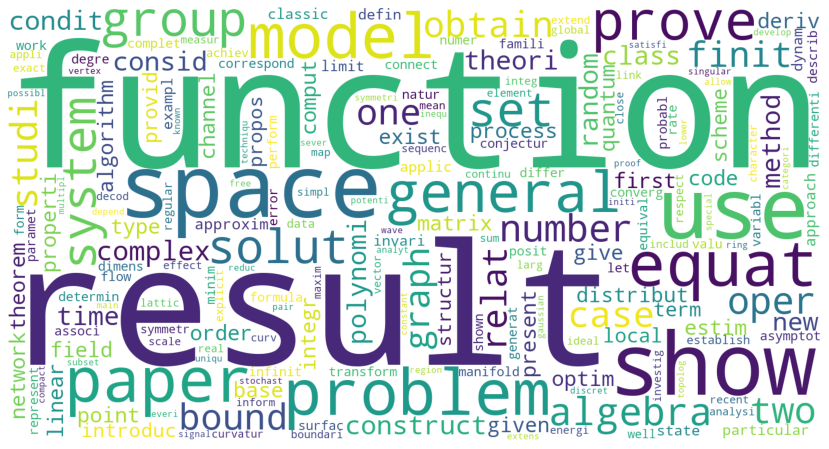

In [15]:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 3. Run LDA Topic Model Using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’.

## What is LDA and how does it work with bag of words?

**Latent Dirichlet Allocation (LDA)** is a popular statistical model for identifying topics in a collection of documents. It is an unsupervised machine learning algorithm that **discovers hidden topics within a corpus of text data**.

The **bag of words (BoW)** approach is a common way to represent text data in which the **order of words is disregarded and each document is represented as a frequency distribution of words**. The BoW model assumes that the presence or absence of words in a document can be used to infer something about the content of the document.

In an LDA model with bag of words, each document is represented as a vector of word counts, and the model assumes that each document is a mixture of multiple topics, where a topic is a probability distribution over words. The model seeks to find the latent topics that best explain the observed word occurrences in the document collection.

LDA with bag of words involves three main steps (packages will do this for us):

1. Initialization: The model starts by randomly assigning each word in each document to one of the possible topics.

2. Iteration: The model iteratively updates the topic assignments for each word in each document based on the topic assignments of the other words in the same document and the overall distribution of topics in the document collection.

3. Output: Once the model has converged to a stable set of topic assignments, it outputs the inferred topic distribution for each document and the word distribution for each topic.

LDA with bag of words can be a powerful tool for understanding the underlying topics and structure in a large corpus of text data.

### Tokenization: Split each text into sentences and the sentences into words. 

In [16]:
def preprocess(text): # tokenization
    result = []
    for token in gensim.utils.simple_preprocess(text):
            result.append(token)
    return [x.encode('utf-8') for x in result]

## Bag of Words on the Data set

Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [17]:
processed_docs = documents['text'].map(preprocess)
id2word = gensim.corpora.Dictionary(processed_docs)
print(id2word)

#Here is the first 5 words in the data dictionary: id + word
count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 4:
        break

Dictionary(11557 unique tokens: ['abderrahman', 'age', 'all', 'analysi', 'asymptot']...)
0 abderrahman
1 age
2 all
3 analysi
4 asymptot


## Filter out tokens that appear in

- less than 3 documents (absolute number)
    
- more than 0.5 documents (fraction of total corpus size, not absolute number)

After the above two steps, keep the top frequent 3000 tokens (optinal)


In [18]:
id2word.filter_extremes(no_below=3, no_above=0.5, keep_n=3000)

## Word count

For each document we create a dictionary reporting how many words and how many times those words appear. 

Save this to ‘bow_corpus’, then check our selected document earlier.

In [19]:
bow_corpus = [id2word.doc2bow(doc) for doc in processed_docs]

An example doc

In [20]:
bow_doc_666 = bow_corpus[666]

for i in range(len(bow_doc_666)):
    print(f"Word {bow_doc_666[i][0]} ({id2word[bow_doc_666[i][0]]}) appears {bow_doc_666[i][1]} time.")

Word 19 (number) appears 1 time.
Word 24 (prove) appears 1 time.
Word 70 (represent) appears 1 time.
Word 147 (requir) appears 1 time.
Word 152 (show) appears 1 time.
Word 527 (rank) appears 1 time.
Word 931 (field) appears 1 time.
Word 945 (evalu) appears 1 time.
Word 1128 (prime) appears 2 time.
Word 1681 (certifi) appears 1 time.
Word 2087 (matroid) appears 2 time.
Word 2210 (jim) appears 1 time.


In [21]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=2)

In [22]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"show" + 0.010*"result" + 0.008*"function" + 0.008*"code" + 0.007*"use" + 0.006*"time" + 0.006*"network" + 0.006*"paper" + 0.006*"prove" + 0.006*"bound"
Topic: 1 
Words: 0.014*"model" + 0.011*"function" + 0.007*"paper" + 0.007*"system" + 0.007*"solut" + 0.006*"estim" + 0.006*"algebra" + 0.006*"equat" + 0.006*"one" + 0.006*"result"
Topic: 2 
Words: 0.011*"space" + 0.008*"quantum" + 0.007*"polynomi" + 0.007*"system" + 0.007*"function" + 0.007*"field" + 0.007*"oper" + 0.006*"problem" + 0.006*"general" + 0.006*"result"
Topic: 3 
Words: 0.013*"graph" + 0.012*"equat" + 0.012*"space" + 0.008*"solut" + 0.007*"also" + 0.007*"group" + 0.007*"function" + 0.006*"result" + 0.006*"oper" + 0.006*"problem"
Topic: 4 
Words: 0.010*"problem" + 0.009*"use" + 0.009*"result" + 0.007*"code" + 0.006*"group" + 0.006*"general" + 0.006*"method" + 0.006*"theori" + 0.006*"inequ" + 0.006*"show"
Topic: 5 
Words: 0.011*"group" + 0.010*"set" + 0.008*"show" + 0.008*"number" + 0.007*"paper" + 0.00

#### Document 666's content about topic _ is ___%.

In [23]:
documents['text'][666]

'certifi nonrepresent matroid prime field jim geelen findmath1auwhittle_g010all01geoff whittlea prove prime number show nelement matroid represent gfp requir on2 rank evalu'

In [24]:
# Document 666's content about topic _ is ___%.
print(lda_model[bow_corpus[666]])

[(0, 0.011242986), (1, 0.011181048), (2, 0.9439763), (3, 0.01115918), (4, 0.011227713), (5, 0.011212783)]


## Visualization

In [25]:
from joblib import Parallel
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id2word)

/Users/harshvardhan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshvardhan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshvardhan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshvardhan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshvardhan/opt/anaconda3/lib/python3.9/

In [26]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.054894 -0.003169       1        1  18.666392
1      0.021839 -0.040043       2        1  18.626710
2     -0.020907 -0.033927       3        1  18.083137
0      0.022864  0.005549       4        1  16.934744
4      0.055678  0.020236       5        1  14.596212
5     -0.024581  0.051354       6        1  13.092805, topic_info=         Term        Freq       Total Category  logprob  loglift
172     graph  218.000000  218.000000  Default  30.0000  30.0000
491      code  164.000000  164.000000  Default  29.0000  29.0000
177   quantum  144.000000  144.000000  Default  28.0000  28.0000
51      group  300.000000  300.000000  Default  27.0000  27.0000
1020    inequ   69.000000   69.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
406   algebra   33.564005  269.450600   Topic6  -5.4280  -0.0498
17      model   33.957122  339.551064   Topic6  -5.4163  -0.2694
144   problem   32.594177  340.422278   Topic6  -5.4573  -0.3129
78      space   27.806749  380.138413   Topic6  -5.6162  -0.5821
423    method   26.968778  186.854612   Topic6  -5.6468   0.0975

[491 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2320      2  0.035742    a_
2320      3  0.464645    a_
2320      6  0.464645    a_
2206      1  0.100009  abel
2206      4  0.800072  abel
...     ...       ...   ...
1767      4  0.127623    yu
1767      5  0.127623    yu
1007      1  0.257448   zhu
1007      3  0.257448   zhu
1007      6  0.514895   zhu

[1503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5, 6])

### An important parameter for LDA is the number of topics.

## Parameter Tuning

In [27]:
import warnings
warnings.filterwarnings('ignore')
from gensim.models import CoherenceModel

# define a helper function
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow_corpus, num_topics=num_topics, id2word=id2word
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts,  coherence='u_mass'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [28]:
# run and save
model_list, coherence_values = coherence_values_computation(
   dictionary=id2word, corpus=bow_corpus, texts=processed_docs, 
   start=2, limit=9, step=1
)

### What is a "good" coherence score?
- Higher is better. But having too many topics can be complicated to interpret.
- https://stackoverflow.com/a/55816086/8057777
- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

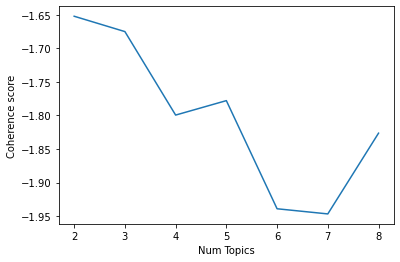

Num Topics = 2  is having Coherence Value of -1.6521
Num Topics = 3  is having Coherence Value of -1.675
Num Topics = 4  is having Coherence Value of -1.7994
Num Topics = 5  is having Coherence Value of -1.7779
Num Topics = 6  is having Coherence Value of -1.9391
Num Topics = 7  is having Coherence Value of -1.9468
Num Topics = 8  is having Coherence Value of -1.8264


In [29]:
# make plot
%matplotlib inline
import matplotlib.pyplot as plt

limit=9; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

# 4. Network Analysis

We will use the `networkx` package to create a network graph of the topics. You can learn more about networkx here: https://networkx.org/documentation/stable/tutorial.html

### Read the json file with authors' information.

In [30]:
import json

with open("/Users/harshvardhan/Library/CloudStorage/Dropbox/Spring 2023/text mining TA/guest lecture 1/2_Authors.json") as json_data:
    data = json.load(json_data)

In [31]:
Authors = pd.Series(data['Author'])

In [32]:
Authors.head()

0                   [Dirk Hundertmark, Shuanglin Shao]
1                        [Jinggang Tan, Jingang Xiong]
2    [Michael Gekhtman, Michael Shapiro, Alek Vains...
3    [Tran Vu Khanh, Stefano Pinton, Giuseppe Zampi...
4                                                 None
dtype: object

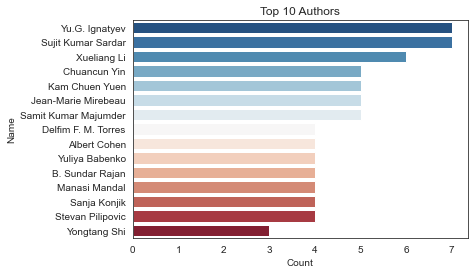

In [33]:
sns.set_style("white")

# Top 10 authors
plt.plot
authors_flat = [
    author
    for authors in list(Authors.dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(15), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


plt.show()

In [34]:
from itertools import combinations
import networkx as nx
from nxviz import CircosPlot

# Extract author connections
authors = Authors.dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]

In [35]:
df_graph

,From,To,Count
0,(1 and 2),Jose Luis Jaramillo,1
1,(2) LUTH,(1 and 2),1
2,(2) LUTH,Carlos F. Sopuerta (3),1
3,(2) LUTH,Jose Luis Jaramillo,1
4,(2) LUTH,Priscilla Canizares (3) ((1) AEI,1
...,...,...,...
2767,Zvi Lotker,Chen Avin,1
2768,Zvi Lotker,Keren Censor-Hillel,1
2769,Zvi Lotker,Michael Borokhovich,1
2770,i. &#xf6;Zg&#xfc;R,M. Akyi\vgit,1


In [36]:
G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)


In [37]:
nx.info(G)

'Graph with 2639 nodes and 2761 edges'

## Graphs

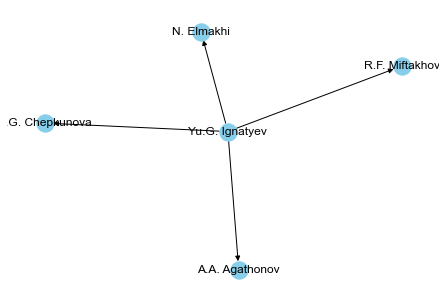

In [38]:
tree = nx.bfs_tree(G, 'Yu.G. Ignatyev')
nx.draw(tree, node_color='skyblue', with_labels=True)

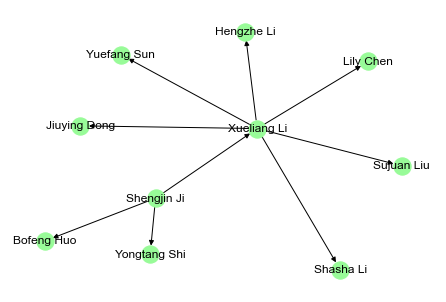

In [46]:
tree2 = nx.bfs_tree(G, 'Shengjin Ji')
nx.draw(tree2, node_color='palegreen', with_labels=True)

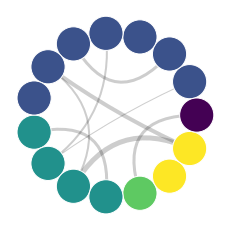

In [40]:
# Limit to TOP 15 authors
top15authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(15), columns=["Name", "Count"]
)

top15_nodes = (n for n in list(G.nodes()) if n in list(top15authors["Name"]))

G_15 = G.subgraph(top15_nodes)

for n in G_15.nodes():
    G_15.nodes[n]["publications"] = int(
        top15authors[top15authors["Name"] == n]["Count"]
    )


c = CircosPlot(
    G_15,
    node_grouping="publications",
    edge_width="Count",
    node_color="publications",
    #legend=True
)

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10, 10
c.draw
plt.show()